In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from pyspark.sql import SparkSession

# Stop any park if running
spark.stop()

# Spark to connect to Mongo
spark = SparkSession.builder \
    .appName("MongoStockTweets") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/META.META") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/META.processed") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.0") \
    .getOrCreate()

# Load database
df = spark.read.format("mongo").load()

df.show(5)


25/05/24 20:47:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/05/24 20:47:42 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/05/24 20:47:42 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


+------------------+------------------+----------+------------------+------------------+------------------+--------+--------------------+
|         Adj Close|             Close|      Date|              High|               Low|              Open|  Volume|                 _id|
+------------------+------------------+----------+------------------+------------------+------------------+--------+--------------------+
|            205.25|            205.25|2019-12-31|205.55999755859375|203.60000610351562|             204.0| 8953500|{682c627079b64044...|
|209.77999877929688|209.77999877929688|2020-01-02| 209.7899932861328|206.27000427246094|            206.75|12077100|{682c627079b64044...|
| 208.6699981689453| 208.6699981689453|2020-01-03|210.39999389648438| 206.9499969482422| 207.2100067138672|11188400|{682c627079b64044...|
|212.60000610351562|212.60000610351562|2020-01-06|212.77999877929688|206.52000427246094| 206.6999969482422|17058900|{682c627079b64044...|
|213.05999755859375|213.0599975585

In [3]:
df.describe().show()

25/05/24 20:47:47 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+----------+------------------+------------------+------------------+--------------------+
|summary|         Adj Close|             Close|      Date|              High|               Low|              Open|              Volume|
+-------+------------------+------------------+----------+------------------+------------------+------------------+--------------------+
|  count|               254|               254|       254|               254|               254|               254|                 254|
|   mean| 234.4355120921698| 234.4355120921698|      null|237.81244160809854| 230.6829926498293|234.22921278345302|2.2393174409448817E7|
| stddev|38.533340652678795|38.533340652678795|      null| 38.85538549738967| 38.49134932572284| 38.75380430544751| 1.041487918878234E7|
|    min|146.00999450683594|146.00999450683594|2019-12-31|148.17999267578125|137.10000610351562|            139.75|             6702000|
|    max| 303.9100036621094| 303.91000366

In [92]:
# # Create MySQL connection
# spark_mysql = SparkSession.builder \
#     .appName("MySQLStockTweets") \
#     .config("spark.jars.packages", "mysql:mysql-connector-java:8.0.29") \
#     .getOrCreate()

# # MySQL connection properties
# url = "jdbc:mysql://127.0.0.1:3306/TSLA"
# properties = {
#     "user": "root",  
#     "password": "password",
#     "driver": "com.mysql.cj.jdbc.Driver"
# }

# df_mysql = spark_mysql.read.jdbc(url=url, table="TSLA", properties=properties)

# df_mysql.show(5)

In [5]:
from pyspark.sql.functions import col, date_format

#checking dates of the week to count if the total values of weekdays are similar 

# Add a new column with the day of the week
df = df.withColumn("weekday", date_format(col("Date"), "EEEE"))

# Show distinct weekdays to verify no weekends are present
df.select("Date", "weekday").distinct().orderBy("Date").show()

# Optional: Count entries per weekday
df.groupBy("weekday").count().orderBy("weekday").show()



+----------+---------+
|      Date|  weekday|
+----------+---------+
|2019-12-31|  Tuesday|
|2020-01-02| Thursday|
|2020-01-03|   Friday|
|2020-01-06|   Monday|
|2020-01-07|  Tuesday|
|2020-01-08|Wednesday|
|2020-01-09| Thursday|
|2020-01-10|   Friday|
|2020-01-13|   Monday|
|2020-01-14|  Tuesday|
|2020-01-15|Wednesday|
|2020-01-16| Thursday|
|2020-01-17|   Friday|
|2020-01-21|  Tuesday|
|2020-01-22|Wednesday|
|2020-01-23| Thursday|
|2020-01-24|   Friday|
|2020-01-27|   Monday|
|2020-01-28|  Tuesday|
|2020-01-29|Wednesday|
+----------+---------+
only showing top 20 rows

+---------+-----+
|  weekday|count|
+---------+-----+
|   Friday|   49|
|   Monday|   48|
| Thursday|   52|
|  Tuesday|   53|
|Wednesday|   52|
+---------+-----+



In [6]:
#Locking for missing values
invalid_close_df = df.filter((col("Close").isNull()) | (col("Close") == 0))
invalid_close_df.show()
print("Invalid rows (Close is null or 0):", invalid_close_df.count())


+---------+-----+----+----+---+----+------+---+-------+
|Adj Close|Close|Date|High|Low|Open|Volume|_id|weekday|
+---------+-----+----+----+---+----+------+---+-------+
+---------+-----+----+----+---+----+------+---+-------+

Invalid rows (Close is null or 0): 0


In [7]:
#Only Date and Close columns
close_df = df.select("Date", "Close")
close_df.show(5)


+----------+------------------+
|      Date|             Close|
+----------+------------------+
|2019-12-31|            205.25|
|2020-01-02|209.77999877929688|
|2020-01-03| 208.6699981689453|
|2020-01-06|212.60000610351562|
|2020-01-07|213.05999755859375|
+----------+------------------+
only showing top 5 rows



In [8]:
close_df.describe().show()

+-------+----------+------------------+
|summary|      Date|             Close|
+-------+----------+------------------+
|  count|       254|               254|
|   mean|      null| 234.4355120921698|
| stddev|      null|38.533340652678795|
|    min|2019-12-31|146.00999450683594|
|    max|2020-12-31| 303.9100036621094|
+-------+----------+------------------+



In [9]:
#Load META data in pandas to be able t work with it
data = close_df.toPandas()
data.head(15)

,Date,Close
0,2019-12-31,205.250000
1,2020-01-02,209.779999
2,2020-01-03,208.669998
3,2020-01-06,212.600006
4,2020-01-07,213.059998
5,2020-01-08,215.220001
6,2020-01-09,218.300003
7,2020-01-10,218.059998
8,2020-01-13,221.910004
9,2020-01-14,219.059998


In [10]:
#LOAD TWEET DATA FROM MONGO

spark.stop()

# Start new SparkSession to load TWEET data
spark = SparkSession.builder \
    .appName("MongoStock") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/TWEET.TWEET") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/TWEET.processed") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.0") \
    .getOrCreate()

tweets_df = spark.read.format("mongo").load()

tweets_df.show(5)


tweets_df.describe().show()

25/05/24 20:47:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/05/24 20:47:50 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/05/24 20:47:50 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


+--------------------+----------+------+------+--------------------+
|                 _id|      date|    id|ticker|               tweet|
+--------------------+----------+------+------+--------------------+
|{682b371e79b64044...|01/01/2020|100004|  TSLA|$TSLA happy new y...|
|{682b371e79b64044...|01/01/2020|100005|  TSLA|$TSLA haha just a...|
|{682b371e79b64044...|01/01/2020|100006|  TSLA|$TSLA NOBODY: Gas...|
|{682b371e79b64044...|02/01/2020|100007|  AAPL|$AAPL $300 calls ...|
|{682b371e79b64044...|02/01/2020|100008|  AAPL|$AAPL Remember, i...|
+--------------------+----------+------+------+--------------------+
only showing top 5 rows

+-------+----------+------------------+------+--------------------+
|summary|      date|                id|ticker|               tweet|
+-------+----------+------------------+------+--------------------+
|  count|     10000|             10000| 10000|               10000|
|   mean|      null|          105000.5|  null|                null|
| stddev|     

In [11]:
#SETING DATETIME AND COPYING ONLY THE COMPANY I WILL USE
tweets_df = tweets_df.toPandas()

tweets_df['date'] = pd.to_datetime(tweets_df['date'], errors='coerce')

tweets_df = tweets_df.dropna(subset=['date'])

META_tweets = tweets_df[tweets_df['ticker'] == 'META'].copy()


In [12]:
META_tweets.describe()

,date,id
count,0,0.0
mean,NaT,NaN
min,NaT,NaN
25%,NaT,NaN
50%,NaT,NaN
75%,NaT,NaN
max,NaT,NaN
std,NaN,NaN


In [13]:
#THERE IS NO META TWEET SO I WILL CHECK WHICH COMPANIES HAVE TWEET IN THE DATA

ticker_counts = tweets_df['ticker'].value_counts().reset_index()
ticker_counts.columns = ['Ticker', 'Tweet_Count']
ticker_counts = ticker_counts.sort_values(by='Tweet_Count', ascending=False)
print(ticker_counts)


   Ticker  Tweet_Count
0    TSLA         1828
1    AAPL          639
2      BA          332
3     DIS          209
4    AMZN          151
5     CCL          107
6     PFE           97
7    MSFT           93
8    BABA           80
9      FB           68
10   NFLX           42
11    WMT           42
12   NVDA           35
13   ABNB           26
14      V           22
15    BAC           21
16     HD           20
17   SBUX           19
18   PYPL           17
19    XOM           16
20    JPM           13
21    MCD            9
22   GOOG            7
23    TSM            6
24  BRK.B            6
25    LOW            6
26    JNJ            5
27  GOOGL            5
29     KO            4
28   BKNG            4
30    UPS            3
31    NKE            3
32    UNH            3
33     MA            2
34     PG            1
35    AMT            1
36    CVX            1


In [14]:
# Filter for TSLA tweets only
TSLA_tweets = tweets_df[tweets_df['ticker'] == 'TSLA'].copy()

In [15]:
TSLA_tweets.describe()

,date,id
count,1828,1828.000000
mean,2020-05-29 19:25:04.595186176,104907.438184
min,2020-01-01 00:00:00,100002.000000
25%,2020-03-02 00:00:00,102671.750000
50%,2020-05-03 00:00:00,105167.000000
75%,2020-09-09 00:00:00,107417.500000
max,2020-12-12 00:00:00,109952.000000
std,NaN,2907.537113


In [16]:
TSLA_tweets.head(20)

,_id,date,id,ticker,tweet
0,"(682b371e79b64044d716fd30,)",2020-01-01,100004,TSLA,"$TSLA happy new year, 2020, everyone🍷🎉🙏"
1,"(682b371e79b64044d716fd31,)",2020-01-01,100005,TSLA,"$TSLA haha just a collection of greats...""Mars..."
2,"(682b371e79b64044d716fd32,)",2020-01-01,100006,TSLA,$TSLA NOBODY: Gas cars driven by humans killed...
15,"(682b371e79b64044d716fd3f,)",2020-03-01,100019,TSLA,$TSLA I must rise to a level where winning do...
16,"(682b371e79b64044d716fd40,)",2020-03-01,100020,TSLA,$TSLA shorts are f u c k e d 💣
17,"(682b371e79b64044d716fd41,)",2020-03-01,100021,TSLA,$TSLA Don’t short. It’s a Trap lol 😂 see you a...
20,"(682b371e79b64044d716fd44,)",2020-03-01,100023,TSLA,$TSLA 🐻 not see anything like this with Tesla ...
21,"(682b371e79b64044d716fd45,)",2020-03-01,100024,TSLA,$TSLA can one hear the bear as it cries in th...
22,"(682b371e79b64044d716fd46,)",2020-03-01,100025,TSLA,$TSLA Ignore the clowns and bears! Marvelous ...
25,"(682b371e79b64044d716fd49,)",2020-01-01,100002,TSLA,$TSLA Daddy's drinkin' eArly tonight! Here's t...


In [17]:
#USING TEXTBOLD TO DO THE TWEETS SENTIMENT ANALYSIS 

from textblob import TextBlob

# Apply TextBlob sentiment polarity
TSLA_tweets['sentiment'] = TSLA_tweets['tweet'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)


In [18]:
TSLA_tweets.head(20)

,_id,date,id,ticker,tweet,sentiment
0,"(682b371e79b64044d716fd30,)",2020-01-01,100004,TSLA,"$TSLA happy new year, 2020, everyone🍷🎉🙏",0.468182
1,"(682b371e79b64044d716fd31,)",2020-01-01,100005,TSLA,"$TSLA haha just a collection of greats...""Mars...",0.500000
2,"(682b371e79b64044d716fd32,)",2020-01-01,100006,TSLA,$TSLA NOBODY: Gas cars driven by humans killed...,-0.200000
15,"(682b371e79b64044d716fd3f,)",2020-03-01,100019,TSLA,$TSLA I must rise to a level where winning do...,0.500000
16,"(682b371e79b64044d716fd40,)",2020-03-01,100020,TSLA,$TSLA shorts are f u c k e d 💣,0.000000
17,"(682b371e79b64044d716fd41,)",2020-03-01,100021,TSLA,$TSLA Don’t short. It’s a Trap lol 😂 see you a...,0.400000
20,"(682b371e79b64044d716fd44,)",2020-03-01,100023,TSLA,$TSLA 🐻 not see anything like this with Tesla ...,0.050000
21,"(682b371e79b64044d716fd45,)",2020-03-01,100024,TSLA,$TSLA can one hear the bear as it cries in th...,0.000000
22,"(682b371e79b64044d716fd46,)",2020-03-01,100025,TSLA,$TSLA Ignore the clowns and bears! Marvelous ...,1.000000
25,"(682b371e79b64044d716fd49,)",2020-01-01,100002,TSLA,$TSLA Daddy's drinkin' eArly tonight! Here's t...,0.156250


In [19]:
# Group by date, take average sentiment per day
daily_sentiment = TSLA_tweets.groupby(TSLA_tweets['date'].dt.date)['sentiment'].mean().reset_index()
daily_sentiment.columns = ['Date', 'Avg_Sentiment']

# Convert Date column to datetime again
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])


In [20]:
daily_sentiment.head(10)

,Date,Avg_Sentiment
0,2020-01-01,0.231108
1,2020-01-02,-0.035000
2,2020-01-04,0.000000
3,2020-01-05,0.099119
4,2020-01-06,0.031746
5,2020-01-07,0.013333
6,2020-01-09,0.120187
7,2020-01-10,0.096950
8,2020-01-12,-0.003622
9,2020-02-01,-0.800000


In [21]:
# GETTING TSLA DATA INSRTEAD OF TSLA

# Stop any park if running
spark.stop()

# CNew Spoark to connect to Mongo
spark = SparkSession.builder \
    .appName("MongoStockTweets") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/TSLA.TSLA") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/TSLA.processed") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.0") \
    .getOrCreate()

# Load TSLA database
df = spark.read.format("mongo").load()

df.show(5)
df.describe().show()

25/05/24 20:47:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/05/24 20:47:55 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/05/24 20:47:55 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


+------------------+------------------+----------+------------------+------------------+------------------+---------+--------------------+
|         Adj Close|             Close|      Date|              High|               Low|              Open|   Volume|                 _id|
+------------------+------------------+----------+------------------+------------------+------------------+---------+--------------------+
|  27.8886661529541|  27.8886661529541|2019-12-31|28.086000442504883| 26.80533218383789|              27.0|154285500|{682c587a79b64044...|
| 28.68400001525879| 28.68400001525879|2020-01-02|28.713333129882812| 28.11400032043457|28.299999237060547|142981500|{682c587a79b64044...|
|29.534000396728516|29.534000396728516|2020-01-03|30.266666412353516|29.128000259399414|29.366666793823242|266677500|{682c587a79b64044...|
|  30.1026668548584|  30.1026668548584|2020-01-06|30.104000091552734|29.333332061767578|29.364667892456055|151995000|{682c587a79b64044...|
|31.270666122436523|31.2706

In [22]:
df = df.withColumn("weekday", date_format(col("Date"), "EEEE"))

# Show distinct weekdays to verify no weekends are present
df.select("Date", "weekday").distinct().orderBy("Date").show()

# Optional: Count entries per weekday
df.groupBy("weekday").count().orderBy("weekday").show()

+----------+---------+
|      Date|  weekday|
+----------+---------+
|2019-12-31|  Tuesday|
|2020-01-02| Thursday|
|2020-01-03|   Friday|
|2020-01-06|   Monday|
|2020-01-07|  Tuesday|
|2020-01-08|Wednesday|
|2020-01-09| Thursday|
|2020-01-10|   Friday|
|2020-01-13|   Monday|
|2020-01-14|  Tuesday|
|2020-01-15|Wednesday|
|2020-01-16| Thursday|
|2020-01-17|   Friday|
|2020-01-21|  Tuesday|
|2020-01-22|Wednesday|
|2020-01-23| Thursday|
|2020-01-24|   Friday|
|2020-01-27|   Monday|
|2020-01-28|  Tuesday|
|2020-01-29|Wednesday|
+----------+---------+
only showing top 20 rows

+---------+-----+
|  weekday|count|
+---------+-----+
|   Friday|   49|
|   Monday|   48|
| Thursday|   52|
|  Tuesday|   53|
|Wednesday|   52|
+---------+-----+



In [23]:
invalid_close_df = df.filter((col("Close").isNull()) | (col("Close") == 0))

invalid_close_df.show()

print("Invalid rows (Close is null or 0):", invalid_close_df.count())


+---------+-----+----+----+---+----+------+---+-------+
|Adj Close|Close|Date|High|Low|Open|Volume|_id|weekday|
+---------+-----+----+----+---+----+------+---+-------+
+---------+-----+----+----+---+----+------+---+-------+

Invalid rows (Close is null or 0): 0


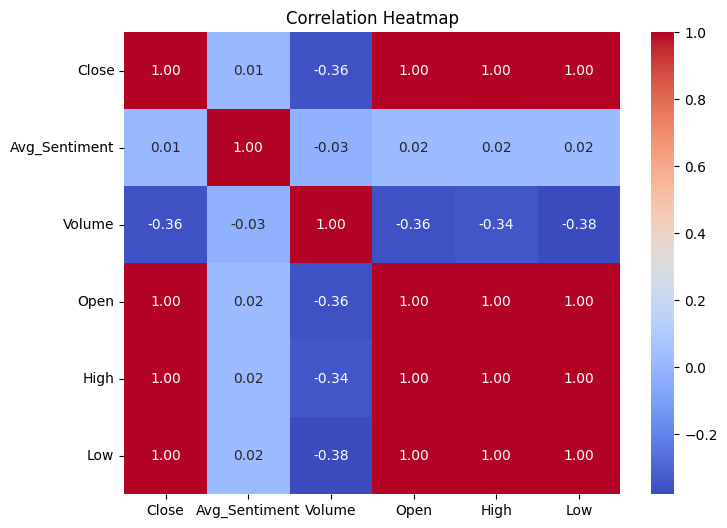

In [24]:
#COORELATION
import pandas as pd
df_pd = df.toPandas()               # ← df is still a Spark DataFrame
daily_sentiment_pd = daily_sentiment  # ← already a Pandas DataFrame


# 2. Ensure datetime format
df_pd['Date'] = pd.to_datetime(df_pd['Date'])
daily_sentiment_pd['Date'] = pd.to_datetime(daily_sentiment_pd['Date'])

# 3. Merge on Date
corr_TSLA = pd.merge(df_pd, daily_sentiment_pd, on='Date', how='left')

# 4. Correlation
corr = corr_TSLA[['Close', 'Avg_Sentiment', 'Volume', 'Open', 'High', 'Low']].corr()

# 5. Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()




This is close to zero, indicating no linear relationship between sentiment and stock closing price.

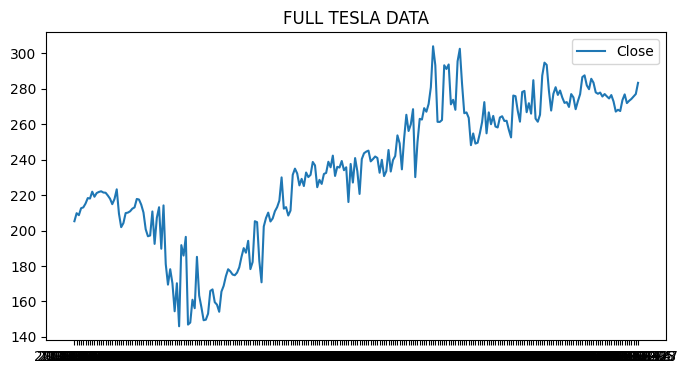

In [25]:
plt.figure(figsize=(8, 4))
plt.plot(data['Date'], data['Close'], label="Close")
plt.legend()
plt.title("FULL TESLA DATA")
plt.show()

In [26]:
# Select only Date and Close columns
close_df = df.select("Date", "Close")

close_df.show(5)

close_df.describe().show()

+----------+------------------+
|      Date|             Close|
+----------+------------------+
|2019-12-31|  27.8886661529541|
|2020-01-02| 28.68400001525879|
|2020-01-03|29.534000396728516|
|2020-01-06|  30.1026668548584|
|2020-01-07|31.270666122436523|
+----------+------------------+
only showing top 5 rows

+-------+----------+------------------+
|summary|      Date|             Close|
+-------+----------+------------------+
|  count|       254|               254|
|   mean|      null| 96.39491312522588|
| stddev|      null| 56.38581517832388|
|    min|2019-12-31| 24.08133316040039|
|    max|2020-12-31|235.22332763671875|
+-------+----------+------------------+



In [27]:
#Load TSLA data in pandas to be able t work with it
data = close_df.toPandas()
data.head(15)

,Date,Close
0,2019-12-31,27.888666
1,2020-01-02,28.684000
2,2020-01-03,29.534000
3,2020-01-06,30.102667
4,2020-01-07,31.270666
5,2020-01-08,32.809334
6,2020-01-09,32.089333
7,2020-01-10,31.876667
8,2020-01-13,34.990665
9,2020-01-14,35.861332


In [28]:
data = data.sort_values('Date')

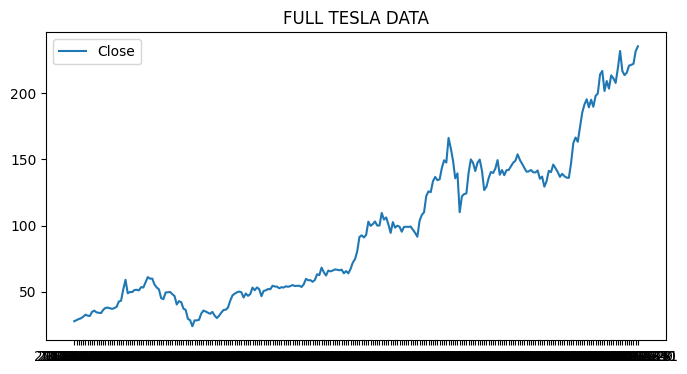

In [29]:
plt.figure(figsize=(8, 4))
plt.plot(data['Date'], data['Close'], label="Close")
plt.legend()
plt.title("FULL TESLA DATA")
plt.show()

In [30]:
#MERGE DATAS

#both Date columns are datetime
data['Date'] = pd.to_datetime(data['Date'])


# Merge — left join to keep only trading dates
combined_TSLA = pd.merge(data, daily_sentiment, on='Date', how='left')

# Fill missing sentiment with 0 (neutral)
combined_TSLA['Avg_Sentiment'] = combined_TSLA['Avg_Sentiment'].fillna(0.0)

print(combined_TSLA.head(40))


         Date      Close  Avg_Sentiment
0  2019-12-31  27.888666       0.000000
1  2020-01-02  28.684000      -0.035000
2  2020-01-03  29.534000       0.000000
3  2020-01-06  30.102667       0.031746
4  2020-01-07  31.270666       0.013333
5  2020-01-08  32.809334       0.000000
6  2020-01-09  32.089333       0.120187
7  2020-01-10  31.876667       0.096950
8  2020-01-13  34.990665       0.000000
9  2020-01-14  35.861332       0.000000
10 2020-01-15  34.566666       0.000000
11 2020-01-16  34.232666       0.000000
12 2020-01-17  34.033333       0.000000
13 2020-01-21  36.480000       0.000000
14 2020-01-22  37.970669       0.000000
15 2020-01-23  38.146667       0.000000
16 2020-01-24  37.654667       0.000000
17 2020-01-27  37.201332       0.000000
18 2020-01-28  37.793331       0.000000
19 2020-01-29  38.732666       0.000000
20 2020-01-30  42.720669       0.000000
21 2020-01-31  43.371334       0.000000
22 2020-02-03  52.000000       0.116435
23 2020-02-04  59.137333       0.066818


In [31]:
combined_TSLA.describe()

,Date,Close,Avg_Sentiment
count,254,254.000000,254.000000
mean,2020-07-01 19:16:32.125984256,96.394913,0.029156
min,2019-12-31 00:00:00,24.081333,-0.306250
25%,2020-04-01 06:00:00,49.886168,0.000000
50%,2020-07-01 12:00:00,77.609665,0.000000
75%,2020-09-30 18:00:00,140.381660,0.000000
max,2020-12-31 00:00:00,235.223328,0.910000
std,NaN,56.385815,0.103693


In [34]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
#from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
#The kernel appears to have died. It will restart automatically.
import torch
#from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader

In [96]:
#SPLITING DATA

combined_df = combined_TSLA.copy()

# Normalize
close_scaler = MinMaxScaler()
combined_df['Close'] = close_scaler.fit_transform(combined_df[['Close']])

sentiment_scaler = MinMaxScaler()
combined_df['Avg_Sentiment'] = sentiment_scaler.fit_transform(combined_df[['Avg_Sentiment']])

# Define sequence length
sequence_length = 28
X, y, y_dates = [], [], []

for i in range(sequence_length, len(combined_df)):
    sequence = combined_df[['Close', 'Avg_Sentiment']].iloc[i-sequence_length:i].values
    target = combined_df['Close'].iloc[i]
    date = combined_df['Date'].iloc[i]  # Track the target's date

    X.append(sequence)
    y.append(target)
    y_dates.append(date)

# Convert
X = np.array(X)
y = np.array(y)
y_dates = pd.to_datetime(y_dates)

# Split
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test,  y_test  = X[train_size:], y[train_size:]
dates_train, dates_test = y_dates[:train_size], y_dates[train_size:]

# Print info
print("Lengths:")
print(f"Total: {len(y)}")
print(f"Train: {len(y_train)}")
print(f"Test : {len(y_test)}")

print("\nDate Ranges:")
print(f"Full data:   {y_dates.min().date()} → {y_dates.max().date()}")
print(f"Train range: {dates_train.min().date()} → {dates_train.max().date()}")
print(f"Test range:  {dates_test.min().date()} → {dates_test.max().date()}")



# # APPLY the PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Wrap in DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



Lengths:
Total: 226
Train: 180
Test : 46

Date Ranges:
Full data:   2020-02-11 → 2020-12-31
Train range: 2020-02-11 → 2020-10-26
Test range:  2020-10-27 → 2020-12-31


254 - 28 = 226

In [97]:
dates_test

DatetimeIndex(['2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30',
               '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05',
               '2020-11-06', '2020-11-09', '2020-11-10', '2020-11-11',
               '2020-11-12', '2020-11-13', '2020-11-16', '2020-11-17',
               '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-23',
               '2020-11-24', '2020-11-25', '2020-11-27', '2020-11-30',
               '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-07', '2020-12-08', '2020-12-09', '2020-12-10',
               '2020-12-11', '2020-12-14', '2020-12-15', '2020-12-16',
               '2020-12-17', '2020-12-18', '2020-12-21', '2020-12-22',
               '2020-12-23', '2020-12-24', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', freq=None)

In [98]:
sort_idx = np.argsort(dates_test)
dates_sorted = dates_test[sort_idx]

In [99]:
dates_sorted

DatetimeIndex(['2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30',
               '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05',
               '2020-11-06', '2020-11-09', '2020-11-10', '2020-11-11',
               '2020-11-12', '2020-11-13', '2020-11-16', '2020-11-17',
               '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-23',
               '2020-11-24', '2020-11-25', '2020-11-27', '2020-11-30',
               '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-07', '2020-12-08', '2020-12-09', '2020-12-10',
               '2020-12-11', '2020-12-14', '2020-12-15', '2020-12-16',
               '2020-12-17', '2020-12-18', '2020-12-21', '2020-12-22',
               '2020-12-23', '2020-12-24', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', freq=None)

In [100]:
combined_df['Close'] 

0      0.018032
1      0.021799
2      0.025825
3      0.028518
4      0.034050
         ...   
249    0.930694
250    0.933725
251    0.937357
252    0.982808
253    1.000000
Name: Close, Length: 254, dtype: float64

In [101]:
combined_df.head(10)

,Date,Close,Avg_Sentiment
0,2019-12-31,0.018032,0.251799
1,2020-01-02,0.021799,0.223022
2,2020-01-03,0.025825,0.251799
3,2020-01-06,0.028518,0.277900
4,2020-01-07,0.034050,0.262761
5,2020-01-08,0.041337,0.251799
6,2020-01-09,0.037927,0.350616
7,2020-01-10,0.036920,0.331510
8,2020-01-13,0.051668,0.251799
9,2020-01-14,0.055792,0.251799


# RNN - LSTM

Recurrent Neural Networks (RNNs), especially Long Short-Term Memory (LSTM) networks, are excellent for time series 
forecasting because they can capture sequential dependencies and temporal patterns in the data. 
They are particularly effective for datasets with smaller amounts of data.

In [102]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score

In [103]:
# LSTM model
class LSTM_Model(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, num_layers=2, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size,
                            num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):  # x shape: (batch, seq_len, features)
        out, (hn, cn) = self.lstm(x)
        return self.fc(hn[-1])  # shape: (batch, 1)

# input_size equal 2 cause it is close and sentimental
lstm_model = LSTM_Model(input_size=2, hidden_size=64, num_layers=2, dropout=0.0).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

# loop
epochs = 20
for ep in range(epochs):
    lstm_model.train()
    train_losses = []

    for xb, yb in train_loader:  
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = lstm_model(xb).squeeze(-1)  
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    print(f"Epoch {ep+1}/{epochs}  Train MSE: {np.mean(train_losses):.6f}")

# test set
lstm_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = lstm_model(xb).squeeze(-1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(yb.cpu().numpy())

#metrics
y_pred = np.array(y_pred)
y_true = np.array(y_true)





Epoch 1/20  Train MSE: 0.077662
Epoch 2/20  Train MSE: 0.031133
Epoch 3/20  Train MSE: 0.036161
Epoch 4/20  Train MSE: 0.042784
Epoch 5/20  Train MSE: 0.038238
Epoch 6/20  Train MSE: 0.033800
Epoch 7/20  Train MSE: 0.029451
Epoch 8/20  Train MSE: 0.025859
Epoch 9/20  Train MSE: 0.023102
Epoch 10/20  Train MSE: 0.018187
Epoch 11/20  Train MSE: 0.011053
Epoch 12/20  Train MSE: 0.007966
Epoch 13/20  Train MSE: 0.007916
Epoch 14/20  Train MSE: 0.022177
Epoch 15/20  Train MSE: 0.004136
Epoch 16/20  Train MSE: 0.009983
Epoch 17/20  Train MSE: 0.013656
Epoch 18/20  Train MSE: 0.006439
Epoch 19/20  Train MSE: 0.006753
Epoch 20/20  Train MSE: 0.008084



Test samples: 46

 LSTM Test MSE: 716.595764   R²: 0.4073


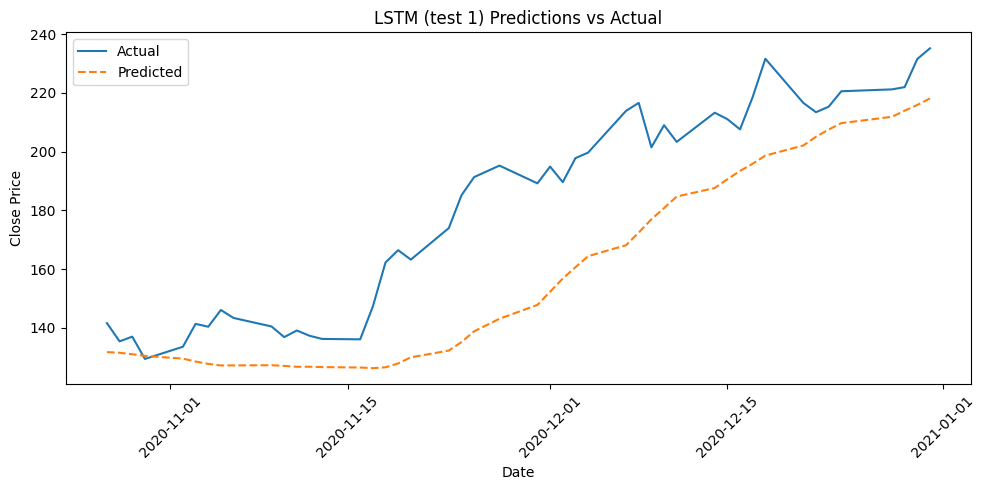

In [104]:

# REVERSING THE ORDER SO THE MSE AND R2 WILL BE UNSACLED  LIKE ARIMAX AS I WILL COMPARE THE RESULTS

y_pred_unscaled = close_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()
y_true_unscaled = close_scaler.inverse_transform(np.array(y_true).reshape(-1, 1)).flatten()


mse = mean_squared_error(y_true_unscaled, y_pred_unscaled)
r2  = r2_score(y_true_unscaled, y_pred_unscaled)

print(f"\nTest samples: {len(y_pred)}")
print(f"\n LSTM Test MSE: {mse:.6f}   R²: {r2:.4f}")


lstm_score_mse = mse
lstm_score_r2 = r2


# PLOT with dates
plt.figure(figsize=(10, 5))
plt.plot(dates_sorted, y_true_unscaled, label="Actual")
plt.plot(dates_sorted, y_pred_unscaled, '--', label="Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("LSTM (test 1) Predictions vs Actual")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [105]:
from itertools import product
#FIND THE BEST PARAMETERS

def train_lstm_model_lite(hidden_size, num_layers, dropout, lr, epochs):
    lstm_model_hyper = LSTM_Model(
        input_size=2,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout
    ).to(device)

    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(lstm_model_hyper.parameters(), lr=lr)

    for ep in range(epochs):
        lstm_model_hyper.train()
        train_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = lstm_model_hyper(xb).squeeze(-1)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

    # Evaluate
    lstm_model_hyper.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds = lstm_model_hyper(xb).squeeze(-1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(yb.cpu().numpy())

    return mean_squared_error(y_true, y_pred)

In [106]:
# Hyperparameter grid
hidden_sizes = [32, 64, 128]
num_layers   = [1, 2]
dropouts     = [0.0, 0.2]
lrs          = [0.001, 0.005]
epochs_list  = [15, 20, 35]

results = []

for hs, nl, do, lr, ep in product(hidden_sizes, num_layers, dropouts, lrs, epochs_list):
    eff_do = do if nl > 1 else 0.0
    print(f"hs={hs}, nl={nl}, do={eff_do}, lr={lr}, ep={ep}")
    mse = train_lstm_model_lite(hs, nl, eff_do, lr, ep)
    results.append({
        'hidden_size': hs,
        'num_layers': nl,
        'dropout': eff_do,
        'lr': lr,
        'epochs': ep,
        'mse': mse
    })

# Find best config
best = min(results, key=lambda x: x['mse'])
best




hs=32, nl=1, do=0.0, lr=0.001, ep=15
hs=32, nl=1, do=0.0, lr=0.001, ep=20
hs=32, nl=1, do=0.0, lr=0.001, ep=35
hs=32, nl=1, do=0.0, lr=0.005, ep=15
hs=32, nl=1, do=0.0, lr=0.005, ep=20
hs=32, nl=1, do=0.0, lr=0.005, ep=35
hs=32, nl=1, do=0.0, lr=0.001, ep=15
hs=32, nl=1, do=0.0, lr=0.001, ep=20
hs=32, nl=1, do=0.0, lr=0.001, ep=35
hs=32, nl=1, do=0.0, lr=0.005, ep=15
hs=32, nl=1, do=0.0, lr=0.005, ep=20
hs=32, nl=1, do=0.0, lr=0.005, ep=35
hs=32, nl=2, do=0.0, lr=0.001, ep=15
hs=32, nl=2, do=0.0, lr=0.001, ep=20
hs=32, nl=2, do=0.0, lr=0.001, ep=35
hs=32, nl=2, do=0.0, lr=0.005, ep=15
hs=32, nl=2, do=0.0, lr=0.005, ep=20
hs=32, nl=2, do=0.0, lr=0.005, ep=35
hs=32, nl=2, do=0.2, lr=0.001, ep=15
hs=32, nl=2, do=0.2, lr=0.001, ep=20
hs=32, nl=2, do=0.2, lr=0.001, ep=35
hs=32, nl=2, do=0.2, lr=0.005, ep=15
hs=32, nl=2, do=0.2, lr=0.005, ep=20
hs=32, nl=2, do=0.2, lr=0.005, ep=35
hs=64, nl=1, do=0.0, lr=0.001, ep=15
hs=64, nl=1, do=0.0, lr=0.001, ep=20
hs=64, nl=1, do=0.0, lr=0.001, ep=35
h

{'hidden_size': 128,
 'num_layers': 1,
 'dropout': 0.0,
 'lr': 0.005,
 'epochs': 20,
 'mse': 0.00155316676432441}

In [108]:
#MODEL with Best parametres
#lstm_model_best

class LSTM_Model_best(nn.Module):
    def __init__(self, input_size=2, hidden_size=128, num_layers=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size,
                            num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):  # x shape: (batch, seq_len, features)
        out, (hn, cn) = self.lstm(x)
        return self.fc(hn[-1])  # shape: (batch, 1)

lstm_model_best = LSTM_Model_best(input_size=2, hidden_size=128, num_layers=1, dropout=0.0).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model_best.parameters(), lr=0.005)

epochs = 20
for ep in range(epochs):
    lstm_model_best.train()
    train_losses = []

    for xb, yb in train_loader:  
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = lstm_model_best(xb).squeeze(-1) 
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    print(f"Epoch {ep+1}/{epochs}  Train MSE: {np.mean(train_losses):.6f}")

lstm_model_best.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = lstm_model_best(xb).squeeze(-1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(yb.cpu().numpy())



Epoch 1/20  Train MSE: 0.044591
Epoch 2/20  Train MSE: 0.051048
Epoch 3/20  Train MSE: 0.030636
Epoch 4/20  Train MSE: 0.023498
Epoch 5/20  Train MSE: 0.021976
Epoch 6/20  Train MSE: 0.031221
Epoch 7/20  Train MSE: 0.051302
Epoch 8/20  Train MSE: 0.016355
Epoch 9/20  Train MSE: 0.022930
Epoch 10/20  Train MSE: 0.026802
Epoch 11/20  Train MSE: 0.021057
Epoch 12/20  Train MSE: 0.014470
Epoch 13/20  Train MSE: 0.009177
Epoch 14/20  Train MSE: 0.006106
Epoch 15/20  Train MSE: 0.005817
Epoch 16/20  Train MSE: 0.002323
Epoch 17/20  Train MSE: 0.002992
Epoch 18/20  Train MSE: 0.002164
Epoch 19/20  Train MSE: 0.002032
Epoch 20/20  Train MSE: 0.001708


In [109]:
# REVERSING THE ORDER SO THE MSE AND R2 WILL BE UNSACLED  LIKE ARIMAX

y_pred_unscaled = close_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()
y_true_unscaled = close_scaler.inverse_transform(np.array(y_true).reshape(-1, 1)).flatten()


mse = mean_squared_error(y_true_unscaled, y_pred_unscaled)
r2  = r2_score(y_true_unscaled, y_pred_unscaled)







Test samples: 46

 LSTM Test MSE: 105.891731   R²: 0.9124


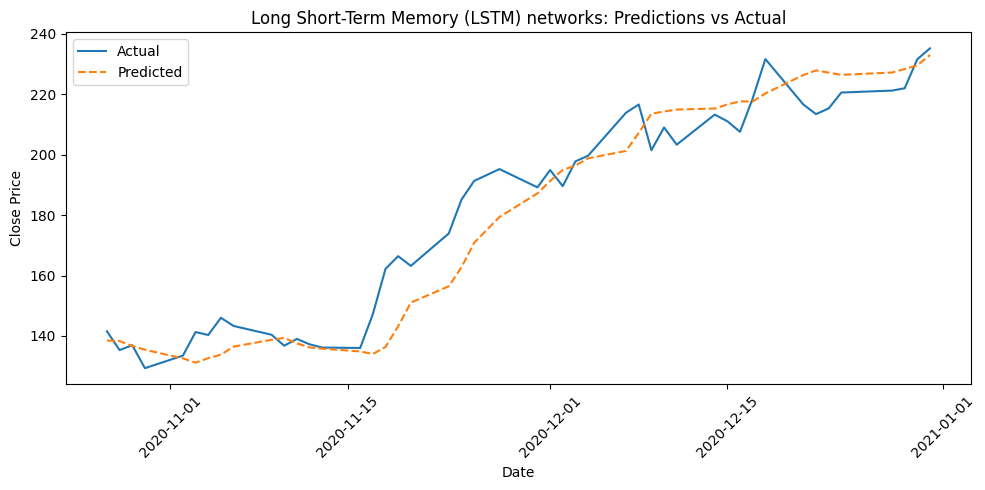

In [110]:
print(f"\nTest samples: {len(y_pred)}")
print(f"\n LSTM Test MSE: {mse:.6f}   R²: {r2:.4f}")

lstm_score_mse_2 = mse
lstm_score_r2_2 = r2


#Plot

plt.figure(figsize=(10, 5))
plt.plot(dates_sorted, y_true_unscaled, label="Actual")
plt.plot(dates_sorted, y_pred_unscaled, '--', label="Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Long Short-Term Memory (LSTM) networks: Predictions vs Actual")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# NN-MLP (Nearest Neighbor Multilayer Perceptron)

In [49]:
import torch.nn as nn

# MLP model (64, 32, 1)
class MLP_Model(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

#Flatten the time-series sequences
# Flatten for MLP: (batch, seq_len, features) → (batch, seq_len * features)
X_train_flat = X_train.view(X_train.shape[0], -1)
X_test_flat  = X_test.view(X_test.shape[0], -1)

# Create DataLoaders for MLP
train_dataset_flat = TensorDataset(X_train_flat, y_train)
test_dataset_flat  = TensorDataset(X_test_flat, y_test)
train_loader_flat  = DataLoader(train_dataset_flat, batch_size=32, shuffle=False)
test_loader_flat   = DataLoader(test_dataset_flat,  batch_size=32, shuffle=False)


#model, loss, optimizer
mlp_model = MLP_Model(input_size=X_train_flat.shape[1]).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=1e-3)

#oop
epochs = 30
for ep in range(epochs):
    mlp_model.train()
    train_losses = []

    for xb, yb in train_loader_flat:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = mlp_model(xb).squeeze(-1)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    print(f"Epoch {ep+1}/{epochs}  Train MSE: {np.mean(train_losses):.6f}")

mlp_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in test_loader_flat:
        xb = xb.to(device)
        preds = mlp_model(xb).squeeze(-1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(yb.cpu().numpy())



Epoch 1/30  Train MSE: 0.049326
Epoch 2/30  Train MSE: 0.018155
Epoch 3/30  Train MSE: 0.011948
Epoch 4/30  Train MSE: 0.014073
Epoch 5/30  Train MSE: 0.011426
Epoch 6/30  Train MSE: 0.007504
Epoch 7/30  Train MSE: 0.004362
Epoch 8/30  Train MSE: 0.003353
Epoch 9/30  Train MSE: 0.003137
Epoch 10/30  Train MSE: 0.002860
Epoch 11/30  Train MSE: 0.002642
Epoch 12/30  Train MSE: 0.002453
Epoch 13/30  Train MSE: 0.002407
Epoch 14/30  Train MSE: 0.002368
Epoch 15/30  Train MSE: 0.002296
Epoch 16/30  Train MSE: 0.002241
Epoch 17/30  Train MSE: 0.002202
Epoch 18/30  Train MSE: 0.002155
Epoch 19/30  Train MSE: 0.002104
Epoch 20/30  Train MSE: 0.002062
Epoch 21/30  Train MSE: 0.002025
Epoch 22/30  Train MSE: 0.001982
Epoch 23/30  Train MSE: 0.001944
Epoch 24/30  Train MSE: 0.001908
Epoch 25/30  Train MSE: 0.001869
Epoch 26/30  Train MSE: 0.001832
Epoch 27/30  Train MSE: 0.001796
Epoch 28/30  Train MSE: 0.001759
Epoch 29/30  Train MSE: 0.001724
Epoch 30/30  Train MSE: 0.001689



 MLP Test MSE: 678.427673   R²: 0.4388


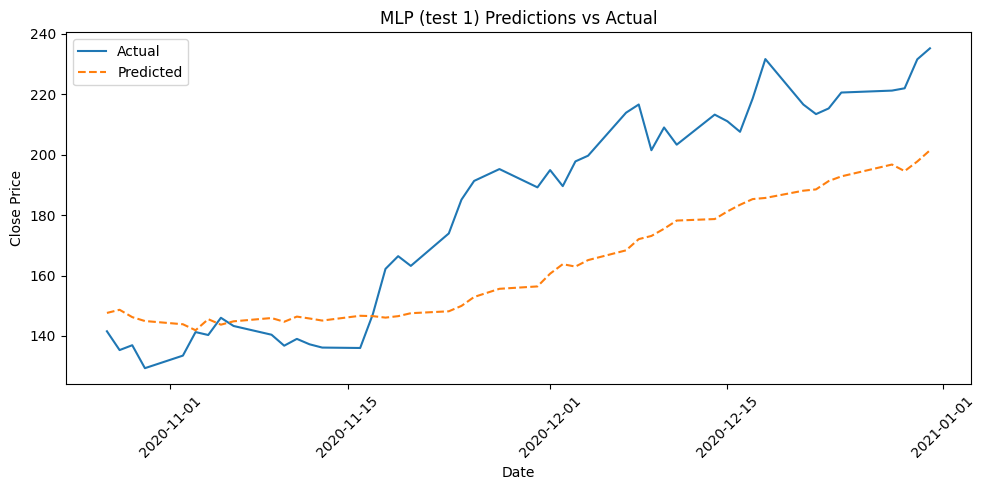

In [50]:
# REVERSING THE ORDER SO THE MSE AND R2 WILL BE UNSACLED  LIKE ARIMAX

y_pred_unscaled = close_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()
y_true_unscaled = close_scaler.inverse_transform(np.array(y_true).reshape(-1, 1)).flatten()


mse = mean_squared_error(y_true_unscaled, y_pred_unscaled)
r2  = r2_score(y_true_unscaled, y_pred_unscaled)

print(f"\n MLP Test MSE: {mse:.6f}   R²: {r2:.4f}")


mlp_score_mse = mse
mlp_score_r2 = r2



#Plot
plt.figure(figsize=(10, 5))
plt.plot(dates_sorted, y_true_unscaled, label="Actual")
plt.plot(dates_sorted, y_pred_unscaled, '--', label="Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("MLP (test 1) Predictions vs Actual")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [111]:
# Hyperparameter options
hidden_sizes = [(64, 32), (128, 64), (64, 64)]
learning_rates = [0.001, 0.005, 0.01]
weight_decays = [0.0, 1e-5]
epoch_options = [20, 30]

results = []


def train_mlp_model(h1, h2, lr, wd, epochs):
    class MLP_Model(nn.Module):
        def __init__(self, input_size):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_size, h1),
                nn.ReLU(),
                nn.Linear(h1, h2),
                nn.ReLU(),
                nn.Linear(h2, 1)
            )

        def forward(self, x):
            return self.net(x)

    mlp_model_hyper = MLP_Model(input_size=X_train_flat.shape[1]).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(mlp_model_hyper.parameters(), lr=lr, weight_decay=wd)

    for ep in range(epochs):
        mlp_model_hyper.train()
        for xb, yb in train_loader_flat:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = mlp_model_hyper(xb).view(-1)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()

    # Evaluation
    mlp_model_hyper.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in test_loader_flat:
            xb = xb.to(device)
            preds = mlp_model_hyper(xb).squeeze(-1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(yb.cpu().numpy())

    mse = mean_squared_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    return mse, r2

# all combinations
for (h1, h2), lr, wd, ep in product(hidden_sizes, learning_rates, weight_decays, epoch_options):
    print(f" Trying H=({h1},{h2}), LR={lr}, WD={wd}, EP={ep}")
    mse, r2 = train_mlp_model(h1, h2, lr, wd, ep)
    results.append({
        'hidden1': h1, 'hidden2': h2, 'lr': lr, 'weight_decay': wd, 'epochs': ep,
        'test_mse': mse, 'test_r2': r2
    })

# best score
best_result = min(results, key=lambda r: r['test_mse'])
print("\n Best MLP Configuration:")
for k, v in best_result.items():
    print(f"{k}: {v:.6f}" if isinstance(v, float) else f"{k}: {v}")


 Trying H=(64,32), LR=0.001, WD=0.0, EP=20
 Trying H=(64,32), LR=0.001, WD=0.0, EP=30
 Trying H=(64,32), LR=0.001, WD=1e-05, EP=20
 Trying H=(64,32), LR=0.001, WD=1e-05, EP=30
 Trying H=(64,32), LR=0.005, WD=0.0, EP=20
 Trying H=(64,32), LR=0.005, WD=0.0, EP=30
 Trying H=(64,32), LR=0.005, WD=1e-05, EP=20
 Trying H=(64,32), LR=0.005, WD=1e-05, EP=30
 Trying H=(64,32), LR=0.01, WD=0.0, EP=20
 Trying H=(64,32), LR=0.01, WD=0.0, EP=30
 Trying H=(64,32), LR=0.01, WD=1e-05, EP=20
 Trying H=(64,32), LR=0.01, WD=1e-05, EP=30
 Trying H=(128,64), LR=0.001, WD=0.0, EP=20
 Trying H=(128,64), LR=0.001, WD=0.0, EP=30
 Trying H=(128,64), LR=0.001, WD=1e-05, EP=20
 Trying H=(128,64), LR=0.001, WD=1e-05, EP=30
 Trying H=(128,64), LR=0.005, WD=0.0, EP=20
 Trying H=(128,64), LR=0.005, WD=0.0, EP=30
 Trying H=(128,64), LR=0.005, WD=1e-05, EP=20
 Trying H=(128,64), LR=0.005, WD=1e-05, EP=30
 Trying H=(128,64), LR=0.01, WD=0.0, EP=20
 Trying H=(128,64), LR=0.01, WD=0.0, EP=30
 Trying H=(128,64), LR=0.01, W

In [112]:
#BEST PARAMETER

class MLP_Model_best(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)
    


# Initialize model, loss, optimizer
mlp_model_best = MLP_Model_best(input_size=X_train_flat.shape[1]).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(mlp_model_best.parameters(), lr=0.01)

# 5. Training loop
epochs = 30
for ep in range(epochs):
    mlp_model_best.train()
    train_losses = []

    for xb, yb in train_loader_flat:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = mlp_model_best(xb).squeeze(-1)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    print(f"Epoch {ep+1}/{epochs}  Train MSE: {np.mean(train_losses):.6f}")

# 6. Evaluation
mlp_model_best.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in test_loader_flat:
        xb = xb.to(device)
        preds = mlp_model_best(xb).squeeze(-1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(yb.cpu().numpy())




Epoch 1/30  Train MSE: 0.043920
Epoch 2/30  Train MSE: 0.045651
Epoch 3/30  Train MSE: 0.014159
Epoch 4/30  Train MSE: 0.029134
Epoch 5/30  Train MSE: 0.072475
Epoch 6/30  Train MSE: 0.036535
Epoch 7/30  Train MSE: 0.013972
Epoch 8/30  Train MSE: 0.013514
Epoch 9/30  Train MSE: 0.008726
Epoch 10/30  Train MSE: 0.005449
Epoch 11/30  Train MSE: 0.005137
Epoch 12/30  Train MSE: 0.004248
Epoch 13/30  Train MSE: 0.003710
Epoch 14/30  Train MSE: 0.003517
Epoch 15/30  Train MSE: 0.003319
Epoch 16/30  Train MSE: 0.003162
Epoch 17/30  Train MSE: 0.003196
Epoch 18/30  Train MSE: 0.003015
Epoch 19/30  Train MSE: 0.003001
Epoch 20/30  Train MSE: 0.002867
Epoch 21/30  Train MSE: 0.002765
Epoch 22/30  Train MSE: 0.002650
Epoch 23/30  Train MSE: 0.002537
Epoch 24/30  Train MSE: 0.002425
Epoch 25/30  Train MSE: 0.002306
Epoch 26/30  Train MSE: 0.002225
Epoch 27/30  Train MSE: 0.002126
Epoch 28/30  Train MSE: 0.002025
Epoch 29/30  Train MSE: 0.002069
Epoch 30/30  Train MSE: 0.001873


In [113]:
# REVERSING THE ORDER SO THE MSE AND R2 WILL BE UNSACLED  LIKE ARIMAX


#Metrics and plot
# mse = mean_squared_error(y_true, y_pred)
# r2 = r2_score(y_true, y_pred)

# print(f"\n📊 MLP Test MSE: {mse:.6f}   R²: {r2:.4f}")

# mlp_score_mse_2 = mse
# mlp_score_r2_2 = r2

#Inverse transform (Close only!)
y_pred_unscaled = close_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()
y_true_unscaled = close_scaler.inverse_transform(np.array(y_true).reshape(-1, 1)).flatten()






 MLP Test MSE: 394.902252   R²: 0.6734


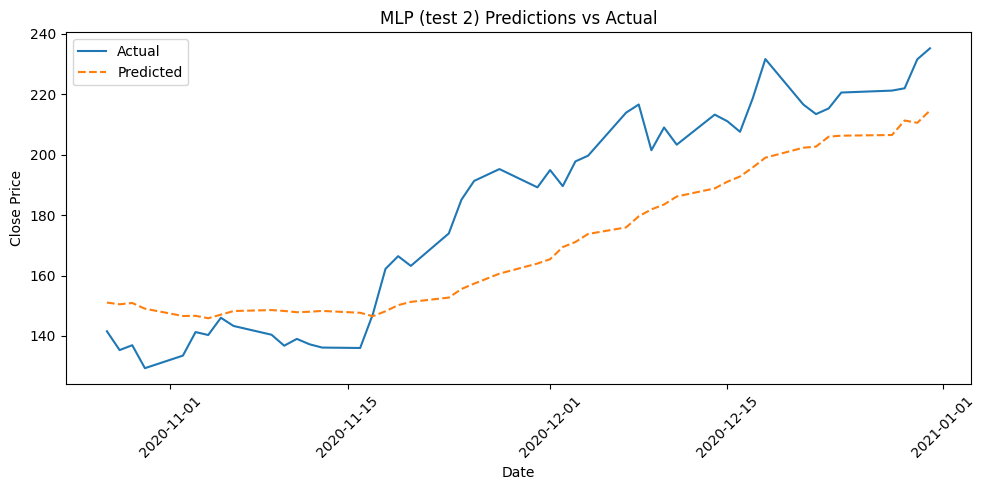

In [114]:
mse = mean_squared_error(y_true_unscaled, y_pred_unscaled)
r2  = r2_score(y_true_unscaled, y_pred_unscaled)

print(f"\n MLP Test MSE: {mse:.6f}   R²: {r2:.4f}")

mlp_score_mse_2 = mse
mlp_score_r2_2 = r2

#Plot
plt.figure(figsize=(10, 5))
plt.plot(dates_sorted, y_true_unscaled, label="Actual")
plt.plot(dates_sorted, y_pred_unscaled, '--', label="Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("MLP (test 2) Predictions vs Actual")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ARIMA

In [55]:
#pip3 install statsmodels
#ARIMAX

In [56]:
TSLA_arimax = combined_TSLA.copy()
# 1. Pull your Mongo/Spark data into pandas
#series = TSLA_arimax.toPandas()

# 2. Parse the Date column
TSLA_arimax["Date"] = pd.to_datetime(TSLA_arimax["Date"])

# 3. Index & sort
TSLA_arimax = TSLA_arimax.set_index("Date").sort_index()

In [57]:
TSLA_arimax

,Close,Avg_Sentiment
Date,,
2019-12-31,27.888666,0.000000
2020-01-02,28.684000,-0.035000
2020-01-03,29.534000,0.000000
2020-01-06,30.102667,0.031746
2020-01-07,31.270666,0.013333
...,...,...
2020-12-24,220.589996,0.000000
2020-12-28,221.229996,0.000000
2020-12-29,221.996674,0.000000


In [58]:
# series = series.dropna()
# print(series.index.freq)            # should be <BusinessDay>  
# print(series.index.inferred_freq)   # should be 'B'

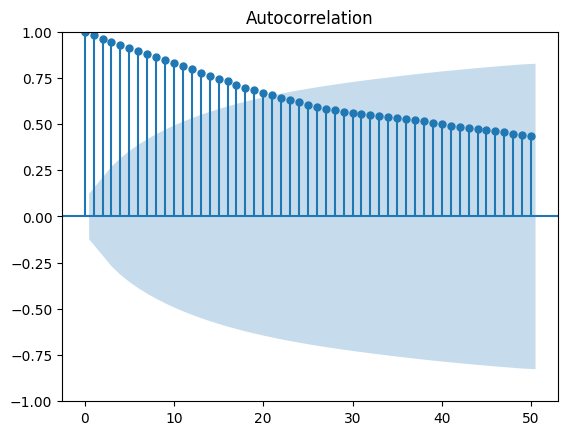

In [59]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(TSLA_arimax['Close'].dropna(), lags=50)
plt.show()


In [60]:
# there is no strong seasanality

In [61]:
from statsmodels.tsa.stattools import adfuller

# 1. Extract your series
#series = df['Date','Close']

# 2. Run ADF test
result = adfuller(TSLA_arimax['Close'])
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value:        {result[1]:.4f}')




ADF Statistic: 0.7974
p-value:        0.9916


In [62]:
# p-value is greater than 0.05 → non-stationary → differencing

In [63]:
diff = TSLA_arimax['Close'].diff().dropna()

result_diff = adfuller(diff)

In [64]:
print(f'ADF Statistic: {result_diff[0]:.4f}')
print(f'p-value:        {result_diff[1]:.4f}')

ADF Statistic: -16.5661
p-value:        0.0000


In [65]:
#the data is now stationary and as we did this process only once,so  d = 1

In [66]:
result = adfuller(TSLA_arimax['Avg_Sentiment'])
print(f"ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")


ADF Statistic: -16.6537, p-value: 0.0000


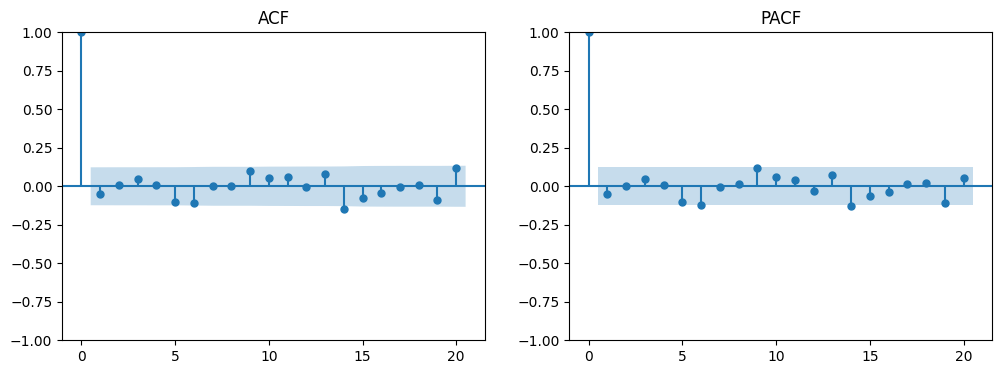

In [67]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#20 trading days ≈ 1 month,
# 1. ACF (for q) and  2. PACF (for p)
fig, axes = plt.subplots(1,2,figsize=(12,4))
plot_acf(diff, lags=20, ax=axes[0])
plot_pacf(diff, lags=20, ax=axes[1])
axes[0].set_title('ACF')
axes[1].set_title('PACF')
plt.show()


The ACF plot shows a significant spike only at lag 1, followed by values that quickly fall within the confidence bounds. This suggests that a moving average (MA) term of order 1 is appropriate. Similarly, the PACF plot shows a significant value at lag 1, with no clear pattern beyond that, indicating that an autoregressive (AR) term of 1 may also be sufficient. Together, this supports choosing a simple ARIMAX model with parameters (p=1, d=1, q=1) after first-order differencing.


In [68]:
#both ACF and PACF cutting off after lag 1
#order = (1, 1, 0)

In [69]:


# series = TSLA_arimax['Close']
# exog_full = TSLA_arimax[['Avg_Sentiment']]  # Only if doing ARIMAX

# model_arima = ARIMA(endog, exog=exog, order=(1, 1, 0))
# fitted = model_arima.fit()

In [70]:
from pandas.tseries.offsets import BDay


In [71]:
#s_full.head(10)

In [72]:
#s_full.info()

import warnings
warnings.filterwarnings("ignore")

In [73]:
# 1. Target and Exogenous
y = TSLA_arimax['Close']
X = TSLA_arimax[['Avg_Sentiment']]

print(y,X)

Date
2019-12-31     27.888666
2020-01-02     28.684000
2020-01-03     29.534000
2020-01-06     30.102667
2020-01-07     31.270666
                 ...    
2020-12-24    220.589996
2020-12-28    221.229996
2020-12-29    221.996674
2020-12-30    231.593338
2020-12-31    235.223328
Name: Close, Length: 254, dtype: float64             Avg_Sentiment
Date                     
2019-12-31       0.000000
2020-01-02      -0.035000
2020-01-03       0.000000
2020-01-06       0.031746
2020-01-07       0.013333
...                   ...
2020-12-24       0.000000
2020-12-28       0.000000
2020-12-29       0.000000
2020-12-30       0.000000
2020-12-31       0.000000

[254 rows x 1 columns]


In [74]:
from statsmodels.tsa.arima.model import ARIMA

# 1. Target and Exogenous
y = TSLA_arimax['Close']
X = TSLA_arimax[['Avg_Sentiment']]

# 2. Train/test split (last 20% for testing)
train_size_ax = int(len(y) * 0.8)
y_train_ax = y.iloc[:train_size_ax]
y_test_ax  = y.iloc[train_size_ax:]

X_train_ax = X.iloc[:train_size_ax]
X_test_ax  = X.iloc[train_size_ax:]


print("Lengths:")
print(f"Total: {len(y)}")
print(f"Train: {len(y_train_ax)}")
print(f"Test : {len(y_test_ax)}")

print("\n Date Ranges:")
print(f"Full data:   {y.index.min().date()} → {y.index.max().date()}")
print(f"Train range: {y_train_ax.index.min().date()} → {y_train_ax.index.max().date()}")
print(f"Test range:  {y_test_ax.index.min().date()} → {y_test_ax.index.max().date()}")







Lengths:
Total: 254
Train: 203
Test : 51

 Date Ranges:
Full data:   2019-12-31 → 2020-12-31
Train range: 2019-12-31 → 2020-10-19
Test range:  2020-10-20 → 2020-12-31



🔎 ARIMAX(1, 1, 1) Test Set Results:
Test MSE: 2352.094776
Test R²:  -0.9050


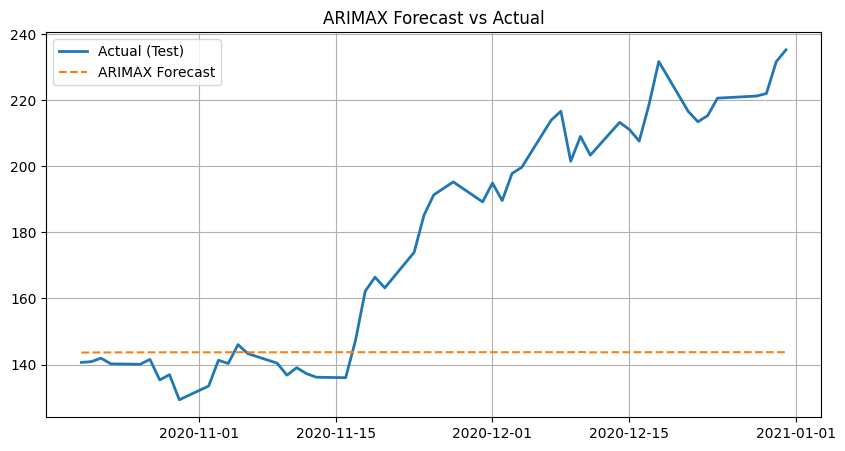

In [117]:

# 3. Fit ARIMAX
order = (1, 1, 1)
model = ARIMA(endog=y_train_ax, exog=X_train_ax, order=order)
fitted = model.fit()

n_test = len(y_test_ax)
# 4. Forecast
forecast = fitted.forecast(steps=n_test, exog=X_test_ax)
forecast.index = y_test_ax.index  # Align for plotting

# 5. Evaluate
mse = mean_squared_error(y_test_ax, forecast)
r2  = r2_score(y_test_ax, forecast)

print(f"\n🔎 ARIMAX{order} Test Set Results:")
print(f"Test MSE: {mse:.6f}")
print(f"Test R²:  {r2:.4f}")

arimax_score_mse = mse
arimax_score_r2 = r2

# 6. Plot
plt.figure(figsize=(10, 5))
plt.plot(y_test_ax, label="Actual (Test)", linewidth=2)
plt.plot(forecast, label="ARIMAX Forecast", linestyle='--')
plt.title("ARIMAX Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.show()

In [76]:
print(X_test_ax['Avg_Sentiment'].value_counts())

Avg_Sentiment
 0.000000    38
 0.073611     1
 0.159342     1
-0.034127     1
 0.109722     1
 0.201860     1
-0.133951     1
 0.053221     1
 0.124479     1
 0.064761     1
 0.059269     1
 0.036111     1
-0.211806     1
 0.357862     1
Name: count, dtype: int64


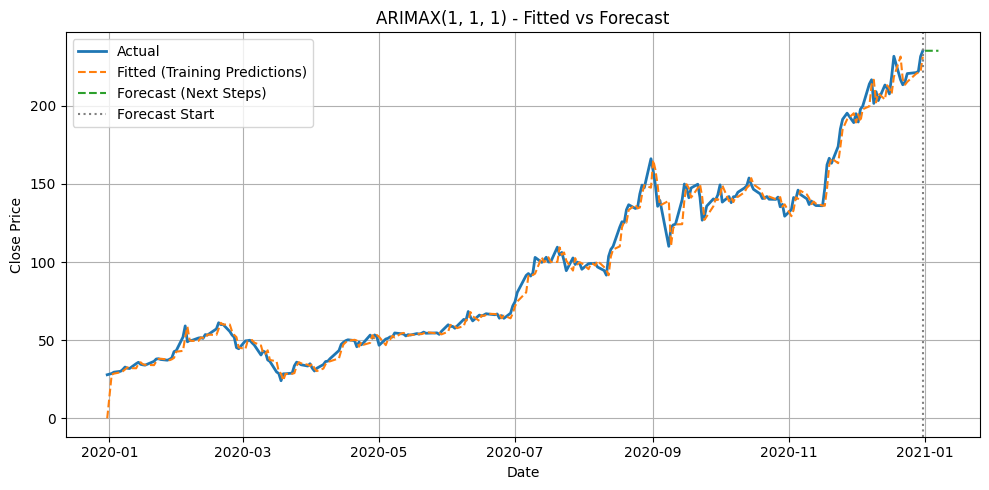

In [116]:
#USING ARIMAX AS THE ORIGINAL WAY (FULL DATA TO CREATE FORECAST)

y = TSLA_arimax['Close']
X = TSLA_arimax[['Avg_Sentiment']]

order = (1, 1, 1)
model = ARIMA(endog=y, exog=X, order=order)
fitted = model.fit()

n_steps = 7  # 7days

# exogenous data
future_sentiment = pd.DataFrame({'Avg_Sentiment': [X['Avg_Sentiment'].iloc[-1]] * n_steps})

# Forecast
forecast_result = fitted.get_forecast(steps=n_steps, exog=future_sentiment)
forecast = forecast_result.predicted_mean


# Create future datetime index
last_date = y.index[-1]
forecast.index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_steps, freq='D')


# Get sample predictions 
fitted_values = fitted.fittedvalues

# Plot
# plt.figure(figsize=(10, 5))
# plt.plot(y, label="Historical", linewidth=2)
# plt.plot(forecast, label="ARIMAX Forecast", linestyle='--')
# plt.title(f"ARIMAX{order} Forecast for Next {n_steps} Steps")
# plt.legend()
# plt.grid(True)
# plt.show()


# Plot
plt.figure(figsize=(10, 5))
plt.plot(y, label="Actual", linewidth=2)
plt.plot(fitted_values, label="Fitted (Training Predictions)", linestyle='--')
plt.plot(forecast, label="Forecast (Next Steps)", linestyle='--')
plt.axvline(x=y.index[-1], color='gray', linestyle=':', label='Forecast Start')
plt.title(f"ARIMAX{order} - Fitted vs Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [78]:
# Hyperparameter ranges
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)

best_score, best_cfg = float("inf"), None
results = []

# Grid search for ARIMAX
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                model_arimax = ARIMA(y_train_ax, order=order, exog=X_train_ax)
                fitted = model_arimax.fit()

                preds = fitted.forecast(steps=len(y_test_ax), exog=X_test_ax)
                mse = mean_squared_error(y_test_ax, preds)
                results.append((order, mse))

                if mse < best_score:
                    best_score = mse
                    best_cfg = order

                print(f"ARIMAX{order} MSE = {mse:.4f}")
            except Exception as e:
                print(f"Failed for order={order} — {e}")
                continue

# Show best config
print(f"\n Best ARIMAX order: {best_cfg} with MSE: {best_score:.4f}")


ARIMAX(0, 0, 0) MSE = 11491.3848
ARIMAX(0, 0, 1) MSE = 11357.2851
ARIMAX(0, 0, 2) MSE = 11316.8036
ARIMAX(0, 0, 3) MSE = 11281.4822
ARIMAX(0, 1, 0) MSE = 2361.1385
ARIMAX(0, 1, 1) MSE = 2353.2403
ARIMAX(0, 1, 2) MSE = 2381.9248
ARIMAX(0, 1, 3) MSE = 2550.4307
ARIMAX(1, 0, 0) MSE = 3155.8368
ARIMAX(1, 0, 1) MSE = 3073.9811
ARIMAX(1, 0, 2) MSE = 3306.3662
ARIMAX(1, 0, 3) MSE = 4060.7837
ARIMAX(1, 1, 0) MSE = 2352.9802
ARIMAX(1, 1, 1) MSE = 2352.0948
ARIMAX(1, 1, 2) MSE = 2446.4800
ARIMAX(1, 1, 3) MSE = 2547.5098
ARIMAX(2, 0, 0) MSE = 3072.5452
ARIMAX(2, 0, 1) MSE = 3159.5940
ARIMAX(2, 0, 2) MSE = 3669.3009
ARIMAX(2, 0, 3) MSE = 4324.4732
ARIMAX(2, 1, 0) MSE = 2373.9834
ARIMAX(2, 1, 1) MSE = 2400.5618
ARIMAX(2, 1, 2) MSE = 2226.9483
ARIMAX(2, 1, 3) MSE = 2493.5092
ARIMAX(3, 0, 0) MSE = 3304.8224
ARIMAX(3, 0, 1) MSE = 3364.1393
ARIMAX(3, 0, 2) MSE = 2858.8811
ARIMAX(3, 0, 3) MSE = 2516.4558
ARIMAX(3, 1, 0) MSE = 2459.0101
ARIMAX(3, 1, 1) MSE = 2457.8656
ARIMAX(3, 1, 2) MSE = 2484.9546
ARIM

In [79]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Hyperparameter ranges
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)

best_score, best_cfg = float("inf"), None
results = []

# Grid search for ARIMAX
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                model_arimax = ARIMA(y_train_ax, order=order, exog=X_train_ax)
                fitted = model_arimax.fit()

                preds = fitted.forecast(steps=len(y_test_ax), exog=X_test_ax)
                mse = mean_squared_error(y_test_ax, preds)
                results.append((order, mse))

                if mse < best_score:
                    best_score = mse
                    best_cfg = order

                print(f"ARIMAX{order} MSE = {mse:.4f}")
            except Exception as e:
                print(f"Failed for order={order} — {e}")
                continue

# Show best config
print(f"\n Best ARIMAX order: {best_cfg} with MSE: {best_score:.4f}")


ARIMAX(0, 0, 0) MSE = 11491.3848
ARIMAX(0, 0, 1) MSE = 11357.2851
ARIMAX(0, 0, 2) MSE = 11316.8036
ARIMAX(0, 0, 3) MSE = 11281.4822
ARIMAX(0, 1, 0) MSE = 2361.1385
ARIMAX(0, 1, 1) MSE = 2353.2403
ARIMAX(0, 1, 2) MSE = 2381.9248
ARIMAX(0, 1, 3) MSE = 2550.4307
ARIMAX(1, 0, 0) MSE = 3155.8368
ARIMAX(1, 0, 1) MSE = 3073.9811
ARIMAX(1, 0, 2) MSE = 3306.3662
ARIMAX(1, 0, 3) MSE = 4060.7837
ARIMAX(1, 1, 0) MSE = 2352.9802
ARIMAX(1, 1, 1) MSE = 2352.0948
ARIMAX(1, 1, 2) MSE = 2446.4800
ARIMAX(1, 1, 3) MSE = 2547.5098
ARIMAX(2, 0, 0) MSE = 3072.5452
ARIMAX(2, 0, 1) MSE = 3159.5940
ARIMAX(2, 0, 2) MSE = 3669.3009
ARIMAX(2, 0, 3) MSE = 4324.4732
ARIMAX(2, 1, 0) MSE = 2373.9834
ARIMAX(2, 1, 1) MSE = 2400.5618
ARIMAX(2, 1, 2) MSE = 2226.9483
ARIMAX(2, 1, 3) MSE = 2493.5092
ARIMAX(3, 0, 0) MSE = 3304.8224
ARIMAX(3, 0, 1) MSE = 3364.1393
ARIMAX(3, 0, 2) MSE = 2858.8811
ARIMAX(3, 0, 3) MSE = 2516.4558
ARIMAX(3, 1, 0) MSE = 2459.0101
ARIMAX(3, 1, 1) MSE = 2457.8656
ARIMAX(3, 1, 2) MSE = 2484.9546
ARIM


 ARIMAX(2, 1, 2) Test Set Results:
Test MSE: 2226.948318
Test R²:  -0.8037


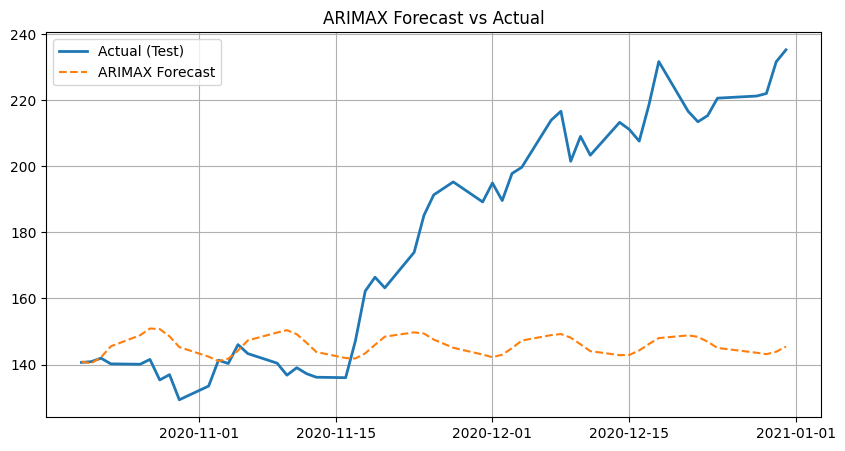

In [80]:
# 3. Fit ARIMAX model (use order from AIC tuning or ACF/PACF suggestion)
order = (2, 1, 2)  # Example
model = ARIMA(endog=y_train_ax, exog=X_train_ax, order=order)
fitted = model.fit()

forecast = fitted.forecast(steps=n_test, exog=X_test_ax)
forecast.index = y_test_ax.index  # Align for plotting

mse = mean_squared_error(y_test_ax, forecast)
r2  = r2_score(y_test_ax, forecast)

print(f"\n ARIMAX{order} Test Set Results:")
print(f"Test MSE: {mse:.6f}")
print(f"Test R²:  {r2:.4f}")

arimax_score_mse_2 = mse
arimax_score_r2_2 = r2

plt.figure(figsize=(10, 5))
plt.plot(y_test_ax, label="Actual (Test)", linewidth=2)
plt.plot(forecast, label="ARIMAX Forecast", linestyle='--')
plt.title("ARIMAX Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.show()

# FINAL SCORES


In [115]:
print("\n Model Performance Summary (MSE and R² on Test Set)")
print("-" * 55)
print(f"{'Model':<15} {'Test':<6} {'MSE':>12} {'R²':>12}")
print("-" * 55)
print(f"{'LSTM':<15} {'1':<6} {lstm_score_mse:12.6f} {lstm_score_r2:12.4f}")
print(f"{'LSTM':<15} {'2':<6} {lstm_score_mse_2:12.6f} {lstm_score_r2_2:12.4f}")
print(f"{'MLP':<15} {'1':<6} {mlp_score_mse:12.6f} {mlp_score_r2:12.4f}")
print(f"{'MLP':<15} {'2':<6} {mlp_score_mse_2:12.6f} {mlp_score_r2_2:12.4f}")
print(f"{'ARIMAX':<15} {'1':<6} {arimax_score_mse:12.6f} {arimax_score_r2:12.4f}")
print(f"{'ARIMAX':<15} {'2':<6} {arimax_score_mse_2:12.6f} {arimax_score_r2_2:12.4f}")

#MSE: lower is better
#R2: closer to 1 is better, around 0 is ok, and negative is worse)



 Model Performance Summary (MSE and R² on Test Set)
-------------------------------------------------------
Model           Test            MSE           R²
-------------------------------------------------------
LSTM            1        716.595764       0.4073
LSTM            2        105.891731       0.9124
MLP             1        678.427673       0.4388
MLP             2        394.902252       0.6734
ARIMAX          1       2352.980229      -0.9058
ARIMAX          2       2226.948318      -0.8037


In [82]:
#LSTM test 2 was the best

In [83]:
#FORECAST USING LSTM
import numpy as np
import torch

def forecast_lstm_multistep2(
    lstm_model_best, 
    last_seq, 
    n_steps, 
    device, 
    use_neutral_sentiment=True, 
    scaler=None, 
    inverse_transform=False,
    seed=None
):


    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    lstm_model_best.eval()
    preds = []

    # Prepare input shape: (1, seq_len, features)
    seq = last_seq.clone().detach().unsqueeze(0).to(device)

    with torch.no_grad():
        for _ in range(n_steps):
            out = lstm_model_best(seq)  # shape: (1, 1)
            pred = out.item()
            preds.append(pred)

            # Handle sentiment
            if use_neutral_sentiment:
                next_sentiment = 0.0
            else:
                next_sentiment = seq[0, -1, 1].item()  # reuse last known sentiment

            # Build next input and slide window
            next_input = torch.tensor([[pred, next_sentiment]], dtype=torch.float32).to(device)
            seq = torch.cat([seq[:, 1:, :], next_input.unsqueeze(0)], dim=1)

    # Optionally inverse-transform to original price
    if inverse_transform and scaler is not None:
        preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()

    return preds



In [84]:
# Get last sequence (already torch.Tensor of shape (seq_len, 2))
last_seq = X_test[-1]

# Forecast 1, 3, and 7 steps using best model
forecast_1 = forecast_lstm_multistep2(
    lstm_model_best, last_seq, n_steps=1, device=device,
    use_neutral_sentiment=True, scaler=close_scaler, inverse_transform=True
)

forecast_3 = forecast_lstm_multistep2(
    lstm_model_best, last_seq, n_steps=3, device=device,
    use_neutral_sentiment=True, scaler=close_scaler, inverse_transform=True
)

forecast_7 = forecast_lstm_multistep2(
    lstm_model_best, last_seq, n_steps=7, device=device,
    use_neutral_sentiment=True, scaler=close_scaler, inverse_transform=True
)

# Display
print("📈 Forecasts (original price scale):")
print("1-day ahead:", forecast_1)
print("3-day ahead:", forecast_3)
print("7-day ahead:", forecast_7)


📈 Forecasts (original price scale):
1-day ahead: [219.57816779]
3-day ahead: [219.57816779 216.68993804 214.69135761]
7-day ahead: [219.57816779 216.68993804 214.69135761 213.00488626 211.43830004
 209.92022916 208.45129028]


In [85]:
print("📈 Forecasts (original price scale):")
print("1-day ahead:", forecast_1)
print("3-day ahead:", forecast_3)
print("7-day ahead:", forecast_7)


📈 Forecasts (original price scale):
1-day ahead: [219.57816779]
3-day ahead: [219.57816779 216.68993804 214.69135761]
7-day ahead: [219.57816779 216.68993804 214.69135761 213.00488626 211.43830004
 209.92022916 208.45129028]


In [86]:
TSLA_arimax.tail(10)

,Close,Avg_Sentiment
Date,,
2020-12-17,218.633331,0.0
2020-12-18,231.666672,0.0
2020-12-21,216.619995,0.0
2020-12-22,213.446671,0.0
2020-12-23,215.326660,0.0
2020-12-24,220.589996,0.0
2020-12-28,221.229996,0.0
2020-12-29,221.996674,0.0
2020-12-30,231.593338,0.0


In [87]:
from datetime import timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

In [88]:
# Drop the sentiment column
TSLA_arimax_clean = TSLA_arimax.drop(columns=['Avg_Sentiment'])



# 1. Add Source label to real data
TSLA_arimax_clean["Source"] = "Actual"

# 2. Prepare 7-day forecast DataFrame
forecast_7_final = forecast_7

TSLA_arimax_clean = TSLA_arimax_clean.reset_index()
last_date = TSLA_arimax_clean["Date"].max()

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
forecast_dates = pd.date_range(start=last_date + us_bd, periods=7, freq=us_bd)


forecast_df = pd.DataFrame({
    "Date": forecast_dates,
    "Close": forecast_7_final,
    "Source": "Forecast"
})

# 3. Combine real + forecasted data
full_df = pd.concat(
    [TSLA_arimax_clean[["Date", "Close", "Source"]], forecast_df],
    ignore_index=True
)

# 4. Save to CSV (clean, with only Date, Close, Source)
full_df.to_csv("TSLA_forecast.csv", index=False)





In [89]:
TSLA_arimax_clean

,Date,Close,Source
0,2019-12-31,27.888666,Actual
1,2020-01-02,28.684000,Actual
2,2020-01-03,29.534000,Actual
3,2020-01-06,30.102667,Actual
4,2020-01-07,31.270666,Actual
...,...,...,...
249,2020-12-24,220.589996,Actual
250,2020-12-28,221.229996,Actual
251,2020-12-29,221.996674,Actual
252,2020-12-30,231.593338,Actual


In [90]:
full_df.tail(20)

,Date,Close,Source
241,2020-12-14,213.276672,Actual
242,2020-12-15,211.083328,Actual
243,2020-12-16,207.589996,Actual
244,2020-12-17,218.633331,Actual
245,2020-12-18,231.666672,Actual
246,2020-12-21,216.619995,Actual
247,2020-12-22,213.446671,Actual
248,2020-12-23,215.326660,Actual
249,2020-12-24,220.589996,Actual
250,2020-12-28,221.229996,Actual
